In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import time 
import numpy as np
import pandas as pd
import data_utils as du
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from hyperspace.kepler.plots import plot_convergence
from hyperspace.kepler.data_utils import load_results

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')

import seaborn as sns
sns.set_style('darkgrid')


%matplotlib inline

# Preprocess

In [3]:
#first we'll start with the NIRONE2-5 absorbance
pathToData = "./../../data/NIRONE2-5/NIRONE2-5_absorbance_dark_1mm.csv"
header=0
with open(pathToData, 'r') as f:
    lines = f.readlines()
for i in range(len(lines)):
    line = lines[i]
    if line[0]=="#":
        header = i+1
    if "#metadataColumns" in line:
        meta = line.strip("\n")
    if "#targetColumns" in line:
        targets = line.strip("\n")
df = pd.read_csv(pathToData, header=header)
metaColumns = meta.split(":")[1].split(",")
targetColumns = targets.split(":")[1].split(",")

In [4]:
dataDF = df.drop(metaColumns+targetColumns, axis = 1)

In [5]:
#get rid of the non-numeric metadata
df = df.drop([col for col in metaColumns if col!='key'], axis = 1)

In [6]:
#take the mean of the replicates  - there are 113 samples
meanDF = df.groupby('key').mean()

# Here we start with the analysis for alcohol

In [7]:
#Divide into categories
meanDF['ALCIR_categories'] = np.ceil(meanDF['ALCIR']/3)
meanDF.ALCIR_categories.value_counts().sort_index()

0.0     3
1.0    27
2.0    24
3.0    44
4.0    15
Name: ALCIR_categories, dtype: int64

In [8]:
#combine categories
meanDF['ALCIR_categories'].where(meanDF['ALCIR_categories']>0,1.0, inplace=True)
meanDF.ALCIR_categories.value_counts().sort_index()

1.0    30
2.0    24
3.0    44
4.0    15
Name: ALCIR_categories, dtype: int64

In [9]:
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2, random_state=42)

for train_index, test_index in split.split(meanDF,meanDF["ALCIR_categories"]):
    trainDF = meanDF.reset_index().loc[train_index]
    testDF = meanDF.reset_index().loc[test_index]

#get rid of the *_categories
meanDF = meanDF.drop("ALCIR_categories", axis=1)
trainDF = trainDF.drop("ALCIR_categories", axis=1)
testDF = testDF.drop("ALCIR_categories", axis=1)

In [10]:
trainDF = trainDF.reset_index(drop=True)
testDF = testDF.reset_index(drop=True)

In [11]:
#perform necessary preprocessing on the data
dropColumns = targetColumns + ['key']
trainSpectra = trainDF.drop(dropColumns,axis=1)
testSpectra = testDF.drop(dropColumns,axis=1)

#scale the data
scaledTrainSpectra = np.transpose(StandardScaler().fit_transform(np.transpose(trainSpectra.values)))
scaledTestSpectra = np.transpose(StandardScaler().fit_transform(np.transpose(testSpectra.values)))

# Now we try SVR with Grid Search (brute force) approach

In [12]:
target = 'ALCIR'
begin = time.time() 
gsc = GridSearchCV(
        estimator=SVR(kernel='rbf'),
        param_grid={
            'C': [0.1, 1, 100, 1000,10000,100000],
            'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
            'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
        },
        cv=9, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
end = time.time() 
grid_result = gsc.fit(scaledTrainSpectra, trainDF[target])
best_params = grid_result.best_params_
best_params

{'C': 1000, 'epsilon': 0.05, 'gamma': 1}

# Now we try SVR with parallel Bayesian SMBO optimization

**First let's save dataset in order to use it with HPO:**

In [13]:
X = scaledTrainSpectra
y = trainDF[target].to_numpy()
targetMetric = 'Alcohol'

data_name = 'data_' + targetMetric + '.npy'

with open(data_name, 'wb') as f:
    np.save(f, X)
    np.save(f, y)

**Now let's retrain our model using cross-validation and the previously obtained parameters so we can compare later on:**

In [14]:
dataset = du.load_data()
reg = SVR()
X, y = dataset[0], dataset[1]

In [15]:
reg.set_params(C=best_params['C'], epsilon=best_params['epsilon'], gamma=best_params['gamma'])

final_results_alcohol_GridSearch = -np.mean(cross_val_score(reg, X, y, cv=9, n_jobs=-1, scoring="neg_mean_squared_error")) #use n_jobs=1 if -1 does not work
print('Negative Mean Squared Error with optimal hyperparameters for the target Alcohol: {}'.format(final_results_alcohol_GridSearch))

Negative Mean Squared Error with optimal hyperparameters for the target Alcohol: 0.10574884764101511


**After getting to this point and having obtained the necessary data along with the previous score, we proceed to do our hyperparameter optimization outside of this notebook. All you need to do is run the following command (in the current directory):**
   
**for 3 params, you will possible need to submit the job to an HPC cluster. If you don't, then just do:**

   **$ mpirun -n 8 python cheers_svr_3params.py --results /path/to/results_dir**
   
**Where n = 2^k, with k = # of hyperparameters and n = # of MPI processes/ranks required**

**Lastly, we can come back to reinstantiate our model with our newly optimized hyperparameters.**

**The plotting functions need to have access to the objective function that was minimized. Let's bring that back into view:**

In [16]:
def objective(params):
    """
    Objective function to be minimized.

    Parameters
    ----------
    * params [list, len(params)=n_hyperparameters]
        Settings of each hyperparameter for a given optimization iteration.
        - Controlled by hyperspaces's hyperdrive function.
        - Order preserved from list passed to hyperdrive's hyperparameters argument.
     """
    C, epsilon, kernel = params

    reg.set_params(C=C, epsilon=epsilon, gamma=gamma)

    return -np.mean(cross_val_score(reg, X, y, cv=9, n_jobs=-1,
                    scoring="neg_mean_squared_error"))

In [17]:
results_alcohol = load_results("./../../results/NIRONE2-5/space3/Alcohol", sort=True)

best_alcohol = results_alcohol.pop(0)

In [18]:
# Get the hyperparameter values
C = best_alcohol.x[0]
epsilon = best_alcohol.x[1]
gamma = best_alcohol.x[2]
print("Hyperparameters of our best model for the target 'Alcohol':\n {}".format(best_alcohol.x))

Hyperparameters of our best model for the target 'Alcohol':
 [468.176335511204, 0.03766331855467733, 1.7363845756700635]


**Retraining the SVR model with Optimal Hyperparameters**

In [19]:
reg.set_params(C=C, epsilon=epsilon, gamma=gamma)

final_results_alcohol = -np.mean(cross_val_score(reg, X, y, cv=9, n_jobs=-1, scoring="neg_mean_squared_error")) #use n_jobs=1 if -1 does not work
print('Negative Mean Squared Error with optimal hyperparameters for the target Alcohol: {}'.format(final_results_alcohol))

Negative Mean Squared Error with optimal hyperparameters for the target Alcohol: 0.0907050246801885


**Finally, let's plot the convergence of the "objective" as a function of the number of iterations.**

**The traces, in this case, the top 8, show the optimization progress at each rank as we run 100 iterations of Bayesian SMBO in parallel. The red trace shows the best performing rank. Each data point represents the function value found at each iteration of the optimization, while the last data point represents the global minimum found.**

**Remember, our objective function here is to minimize the negative cross validation score of our model over 9 folds of the data. The scoring metric used for the cross-validation will be the negative mean absolute error.**

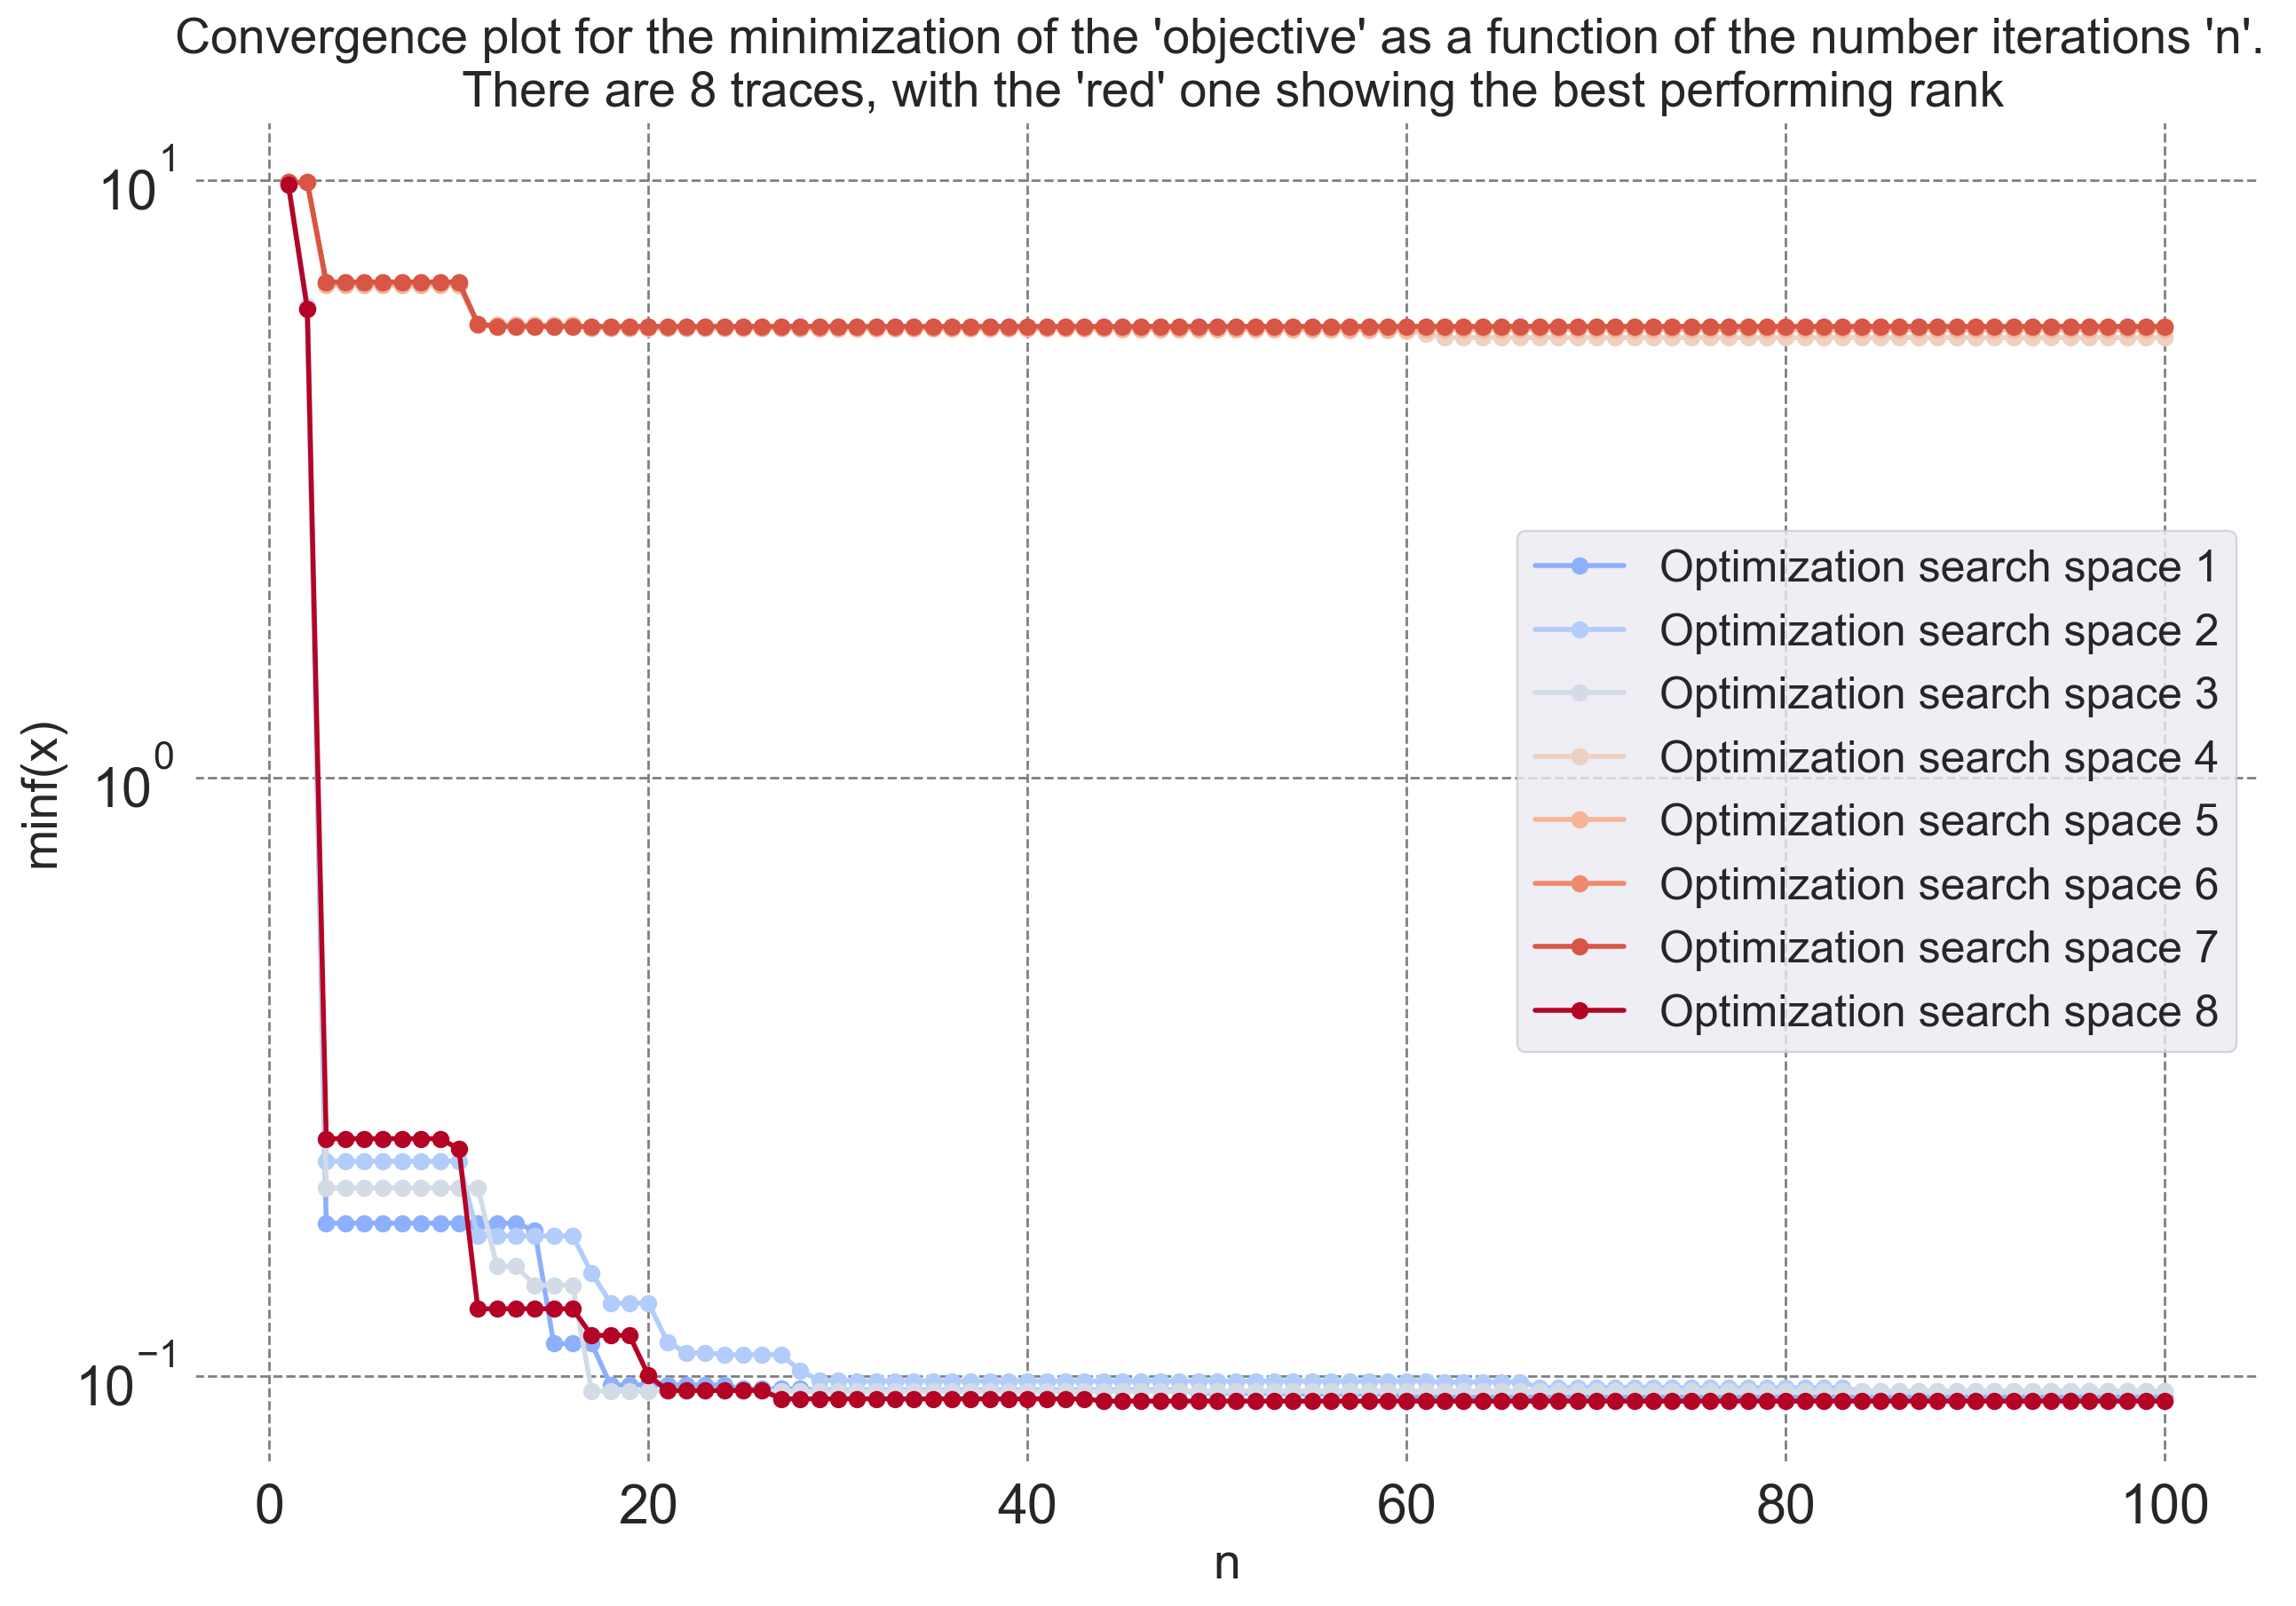

In [20]:
fig, ax = plot_convergence(results_alcohol[0], results_alcohol[1], results_alcohol[2], results_alcohol[3], results_alcohol[4], results_alcohol[5], results_alcohol[6], best_alcohol)
ax.set_facecolor('white')
ax.set_title("Convergence plot for the minimization of the 'objective' as a function of the number iterations 'n'. \n There are 8 traces, with the 'red' one showing the best performing rank", loc='center', fontsize=20)
ax.set_xlabel("n", fontsize=20)
ax.set_ylabel("minf(x)", fontsize=20)
ax.set_yscale("log")
ax.grid(True, color='grey', linestyle='--', linewidth=1)
ax.legend(['Optimization search space 1', 'Optimization search space 2', 'Optimization search space 3', 'Optimization search space 4', 'Optimization search space 5', 'Optimization search space 6', 'Optimization search space 7', 'Optimization search space 8'], prop={'size': 18})

**It is worth noting that the search spaces are continuous. Therefore, there is an automatic improvement over the discrete brute force (Grid Search) solution provided before.**

# Results

**Finally, for the target Alcohol:**

In [21]:
print('Optimal Hyperparameters using Grid Search: \n C = {} \n epsilon = {} \n gamma = {}'.format(best_params['C'], best_params['epsilon'], best_params['gamma']))
print('Optimal Hyperparameters using parallel Bayesian SMBO: \n C = {} \n epsilon = {} \n gamma = {}'.format(C, epsilon, gamma))

Optimal Hyperparameters using Grid Search: 
 C = 1000 
 epsilon = 0.05 
 gamma = 1
Optimal Hyperparameters using parallel Bayesian SMBO: 
 C = 468.176335511204 
 epsilon = 0.03766331855467733 
 gamma = 1.7363845756700635


In [22]:
print('Negative Mean Squared Error using Grid Search (brute force): {}'.format(final_results_alcohol_GridSearch))
print('Negative Mean Squared Error using parallel Bayesian SMBO: {}'.format(final_results_alcohol))

Negative Mean Squared Error using Grid Search (brute force): 0.10574884764101511
Negative Mean Squared Error using parallel Bayesian SMBO: 0.0907050246801885


**Lastly, the TTX (Total Time of Execution) required for the different approaches is:**

In [23]:
print('Grid Search: {:0.2f} microseconds'.format((end-begin)*10**6))
print('Parallel Bayesian SMBO using RADICAL-EnTK (3 params, 8 cores, 100 iterations): 145.96 seconds')

Grid Search: 139.95 microseconds
Parallel Bayesian SMBO using RADICAL-EnTK (3 params, 8 cores, 100 iterations): 145.96 seconds
